## 任务描述：

### 如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

### 实践内容：利用飞桨动态图搭建一个**卷积神经网络**，对包含斑马线的马路和不包含斑马线的马路图像进行分类。

### 特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

In [1]:
import os
import zipfile
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from paddle.io import Dataset
import paddle.nn.functional as F

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 50, 50],                                #输入图片的shape
    "class_dim": 2,                                          #分类数
    "src_path":"data/data55217/Zebra.zip",                    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "label_dict":{'0':'zebra crossing','1':'others'},         #标签字典
    "num_epochs": 2,                                         #训练轮数
    "train_batch_size": 16,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.01                                            #超参数学习率
    }, 
    'skip_steps': 5,                                         #每N个批次打印一次结果
    'save_steps': 10,                                         #每N个批次保存一次模型参数
    "checkpoints": "/home/aistudio/work/checkpoints"          #保存的路径

}

# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [3]:

#解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "zebra crossing")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

In [4]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    data_list_path_1=target_path+"zebra crossing/"
    data_list_path_2=target_path+"others/"
    class_dirs = os.listdir(data_list_path_1)
    all_data_list = []

    for im in os.listdir(data_list_path_1):
        img_path = target_path+"zebra crossing/" + im
        all_data_list.append(img_path + '\t' + '0'+'\n')
 
    for im in os.listdir(data_list_path_2):
        img_path = target_path+"others/" + im
        all_data_list.append(img_path + '\t' + '1' + '\n')

    #对列表进行乱序
    random.shuffle(all_data_list)

    with open(train_list_path, 'a') as f1:
        with open(eval_list_path, 'a') as f2:
            for ind, img_path_label in enumerate(all_data_list):
                #划分测试集和训练集
                if ind % 10 == 0:
                    f2.write(img_path_label) 
                else:
                    f1.write(img_path_label)
    print ('生成数据列表完成！')

In [5]:
#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

文件已存在
生成数据列表完成！


In [6]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [7]:
#训练数据加载
train_dataset = dataset('/home/aistudio/data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, 
                                    batch_size=train_parameters['train_batch_size'], 
                                    shuffle=True
                                    )
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset,
                                   batch_size=train_parameters['train_batch_size'], 
                                   shuffle=False
                                   )

In [8]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/zebra crossing/62.png 	标签值 0
397
文件名 /home/aistudio/data/zebra crossing/97.png 	标签值 0
45
(3, 50, 50)
(1,)


# **二、模型配置**



In [9]:
#定义卷积网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=50, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=50, out_channels=100, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=100, out_channels=100, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=8100, out_features=100)
        self.linear2 = paddle.nn.Linear(in_features=100, out_features=2)

    #网络的前向计算过程
    def forward(self,input):
        output1 = self.conv1(input)
        output1 = F.relu(output1)
        output1 = self.pool1(output1)

        output2 = self.conv2(output1)
        output2 = F.relu(output2)
        output2 = self.pool2(output2)

        output3 = self.conv3(output2)
        output3 = F.relu(output3)

        output4 = self.flatten(output3)
        output5 = self.linear1(output4)
        output5 = F.relu(output5)
        output6 = self.linear2(output5)
        return output6

# **三、模型训练 && 四、模型评估**

In [10]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epo: 0, step: 5, loss is: [2.0376985], acc is: [0.3125]
epo: 0, step: 10, loss is: [0.64254534], acc is: [0.625]
save model to: /home/aistudio/work/checkpoints/save_dir_10.pdparams
epo: 0, step: 15, loss is: [0.74124146], acc is: [0.1875]
epo: 0, step: 20, loss is: [0.7377455], acc is: [0.375]
save model to: /home/aistudio/work/checkpoints/save_dir_20.pdparams
epo: 0, step: 25, loss is: [0.6549097], acc is: [0.53846157]
epo: 1, step: 30, loss is: [0.5770879], acc is: [0.6875]
save model to: /home/aistudio/work/checkpoints/save_dir_30.pdparams
epo: 1, step: 35, loss is: [0.46858868], acc is: [0.6875]
epo: 1, step: 40, loss is: [0.42982608], acc is: [0.8125]
save model to: /home/aistudio/work/checkpoints/save_dir_40.pdparams
epo: 1, step: 45, loss is: [0.45506102], acc is: [0.875]
epo: 1, step: 50, loss is: [0.43529642], acc is: [0.84615386]
save model to: /home/aistudio/work/checkpoints/save_dir_50.pdparams


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


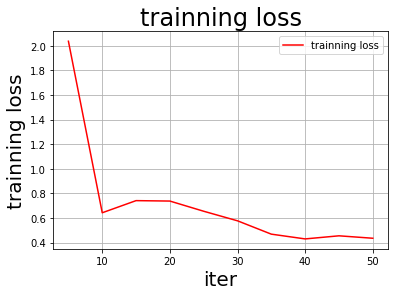

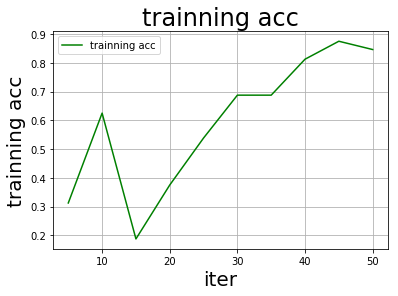

In [11]:
model = MyCNN()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 
                                  
steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        loss = cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

In [12]:

'''
模型预测
'''
model__state_dict = paddle.load('/home/aistudio/work/checkpoints/save_dir_final.pdparams')
model_eval = MyCNN()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []

for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.911859


# **五、模型预测**

In [13]:

def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path)
    # print(img.mode)
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((50, 50), Image.ANTIALIAS)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255  # HWC to CHW 并像素归一化
    return img

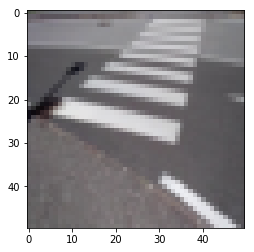

Tensor(shape=[1, 2], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[-0.20048264, -1.90429127]])
Zebra crossing:0.85, Others:0.15


In [14]:

model__state_dict = paddle.load('/home/aistudio/work/checkpoints/save_dir_final.pdparams')
model_predict = MyCNN()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
infer_path='/home/aistudio/data/zebra crossing/10.png'
infer_img = Image.open(infer_path)
plt.imshow(infer_img)          #根据数组绘制图像
plt.show()                     #显示图像
#对预测图片进行预处理
infer_img = load_image(infer_path)
# print(type(infer_img))
infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,50,50)
infer_img = paddle.to_tensor(infer_img)
results = model_predict(infer_img)
print(results)
results = paddle.nn.functional.softmax(results)
print("Zebra crossing:{:.2f}, Others:{:.2f}" .format(results.numpy()[0][0],results.numpy()[0][1]))